In [1]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git
!pip install torchvision datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.3 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-5plyf4hn
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-5plyf4hn
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 60.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 59.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")


Using device: cuda


In [3]:
import clip

# Load CLIP Model (ViT-B/32) and move it to GPU
model, preprocess = clip.load("ViT-B/32", device=device)

# Print Model Information
print(f"Model Input Resolution: {model.visual.input_resolution}")
print(f"Context Length: {model.context_length}")
print(f"Vocabulary Size: {model.vocab_size}")


100%|███████████████████████████████████████| 338M/338M [00:04<00:00, 70.9MiB/s]


Model Input Resolution: 224
Context Length: 77
Vocabulary Size: 49408


In [4]:
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define transforms for CLIP
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize for CLIP
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load CIFAR-10 dataset
dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# Get CIFAR-10 class names
cifar_classes = dataset.classes

# Function to Convert Labels to Text Descriptions
def get_text_labels(labels):
    return [f"A photo of a {cifar_classes[label]}" for label in labels]

# Test Sample
images, labels = next(iter(dataloader))
texts = get_text_labels(labels)

print(f"Sample Texts: {texts[:5]}")


100%|██████████| 170M/170M [00:05<00:00, 30.2MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Sample Texts: ['A photo of a deer', 'A photo of a ship', 'A photo of a horse', 'A photo of a frog', 'A photo of a bird']


In [5]:
# Freeze all layers except the last few
for param in model.parameters():
    param.requires_grad = False  # Freeze all layers

# Unfreeze the last 2 transformer layers
for param in model.visual.transformer.resblocks[-2:].parameters():
    param.requires_grad = True

for param in model.transformer.resblocks[-2:].parameters():
    param.requires_grad = True

# Print Trainable Parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable Parameters: {trainable_params}")


Trainable Parameters: 20480512


In [6]:
import clip
import torch
import torch.optim as optim
import torch.nn as nn
from torch.amp import autocast, GradScaler
from torch.utils.data import DataLoader

# Enable CUDA optimizations
torch.backends.cudnn.benchmark = True
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
torch.backends.cuda.matmul.allow_fp16_reduced_precision_reduction = True  # ✅ Faster AMP computation

device = "cuda" if torch.cuda.is_available() else "cpu"

# ✅ Load CLIP model correctly
model, preprocess = clip.load("ViT-B/32", device=device)

# ✅ Ensure Model is in FP32 (Prevents FP16 Grad Error)
model.to(torch.float32)

# ✅ Compile Model for Faster Execution (Only for PyTorch 2.0+)
if torch.__version__ >= "2.0.0":
    model = torch.compile(model)

# ✅ Ensure Model Parameters Require Gradients
for param in model.parameters():
    param.requires_grad = True

# ✅ Move Model to Training Mode
model.train()

OptimizedModule(
  (_orig_mod): CLIP(
    (visual): VisionTransformer(
      (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
      (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (transformer): Transformer(
        (resblocks): Sequential(
          (0): ResidualAttentionBlock(
            (attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
            )
            (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (mlp): Sequential(
              (c_fc): Linear(in_features=768, out_features=3072, bias=True)
              (gelu): QuickGELU()
              (c_proj): Linear(in_features=3072, out_features=768, bias=True)
            )
            (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          )
          (1): ResidualAttentionBlock(
            (attn): MultiheadAttention(
              (out_proj): NonDynamicallyQu

In [7]:

# Define Contrastive Loss
class ContrastiveLoss(nn.Module):
    def __init__(self, temperature=0.07):
        super().__init__()
        self.temperature = temperature

    def forward(self, image_features, text_features):
        logits = (image_features @ text_features.T) / self.temperature
        labels = torch.arange(len(image_features)).to(image_features.device)
        loss = nn.CrossEntropyLoss()(logits, labels)
        return loss

# ✅ Increase Batch Size for Higher GPU Utilization
batch_size = 128  # ✅ Adjust dynamically based on available GPU memory

# ✅ Optimize DataLoader (Faster Data Loading)
dataloader = DataLoader(
    dataset, batch_size=batch_size, shuffle=True,
    pin_memory=True, num_workers=4  # ✅ Use 4 workers for faster data loading
)

# ✅ Define Optimizer & Mixed Precision GradScaler
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5)
scaler = torch.amp.GradScaler("cuda")  # Updated for PyTorch 2.0+

# ✅ Enable Gradient Accumulation (Reduces CPU-GPU Communication)
gradient_accumulation_steps = 4  # ✅ Accumulate gradients for 4 batches before updating

# ✅ Training Loop
num_epochs = 5
for epoch in range(num_epochs):
    total_loss = 0
    optimizer.zero_grad()  # ✅ Clear gradients before accumulation
    for step, (images, labels) in enumerate(dataloader):
        # Move images to GPU
        images = images.to(device, non_blocking=True)

        # Convert Labels to Text and Tokenize
        texts = get_text_labels(labels)
        text_inputs = clip.tokenize(texts).to(device, non_blocking=True)

        # Use mixed precision for faster computation
        with torch.amp.autocast("cuda"):
            image_features = model.encode_image(images)
            text_features = model.encode_text(text_inputs)

            # Normalize Features (Avoid In-Place Operations)
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)
            text_features = text_features / text_features.norm(dim=-1, keepdim=True)

            # Compute Loss
            loss = ContrastiveLoss()(image_features, text_features)

        # ✅ Fix: Skip Step if Loss is NaN or Inf
        if torch.isnan(loss) or torch.isinf(loss):
            print("Warning: Skipping batch due to NaN/Inf loss")
            continue

        # Scale loss for mixed precision
        scaler.scale(loss).backward()  # ✅ Scale loss first

        # ✅ Gradient Accumulation: Only Update Every `gradient_accumulation_steps`
        if (step + 1) % gradient_accumulation_steps == 0 or (step + 1) == len(dataloader):
            scaler.unscale_(optimizer)  # ✅ Unscale before updating

            # ✅ Clip Gradients to Prevent Instability
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            scaler.step(optimizer)
            scaler.update()  # ✅ Always update scaler
            optimizer.zero_grad()  # ✅ Reset gradients after accumulation

        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss / len(dataloader):.4f}")

    # ✅ Print GPU Usage
    print(f"GPU Memory Used: {torch.cuda.memory_allocated() / 1e9:.2f} GB")


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 1, Loss: 2.7657
GPU Memory Used: 1.90 GB
Epoch 2, Loss: 2.6337
GPU Memory Used: 1.90 GB
Epoch 3, Loss: 2.6111
GPU Memory Used: 1.90 GB
Epoch 4, Loss: 2.6036
GPU Memory Used: 1.90 GB
Epoch 5, Loss: 2.6011
GPU Memory Used: 1.90 GB


In [12]:
import numpy as np
from PIL import Image

# Load a Test Image
test_image = preprocess(Image.open("test_image.jpeg")).unsqueeze(0).to(device)

# Define Sample Text Prompts
test_texts = ["A photo of a cat", "A photo of a dog", "A photo of a car"]
text_inputs = clip.tokenize(test_texts).to(device)

# Extract Features
with torch.no_grad():  # ✅ Prevent gradients from being tracked
    image_features = model.encode_image(test_image)
    text_features = model.encode_text(text_inputs)

    # Normalize Features
    image_features = image_features / image_features.norm(dim=-1, keepdim=True)
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)

    # Compute Cosine Similarity
    similarity = (text_features @ image_features.T).detach().cpu().numpy()  # ✅ FIXED

print(f"Similarity Scores: {similarity}")


Similarity Scores: [[ 0.665462  ]
 [-0.07498755]
 [-0.10489127]]


#### **📌 What Does This Mean?**
| **Text Prompt**           | **Similarity Score**  | **Interpretation** |
|--------------------------|----------------------|--------------------|
| `"A photo of a cat"`    | `0.665462`  | **High similarity** → The image is likely a cat! |
| `"A photo of a dog"`    | `-0.07498755`  | **Low similarity** → The image is not a dog. |
| `"A photo of a car"`    | `-0.10489127`  | **Very low similarity** → The image is not a car at all. |

---

### **📌 How to Interpret Similarity Scores?**
- **Positive & Close to 1** → **Very Similar**  
- **Around 0** → **Unrelated or Unclear**  
- **Negative** → **Very Different**  

Since **`0.665462` is the highest**, it means the **model strongly believes the image is of a cat**.

---


In [16]:
import numpy as np
from PIL import Image
import torch
import clip

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# Load and preprocess the test image
test_image = preprocess(Image.open("test_images/test1.jpeg")).unsqueeze(0).to(device)

# Define sample text prompts
test_texts = ["A photo of a dog", "A photo of a car", "A photo of a tiger","A photo of a cat", "A cute kitten"]
text_inputs = clip.tokenize(test_texts).to(device)

# Extract Features
with torch.no_grad():
    image_features = model.encode_image(test_image)
    text_features = model.encode_text(text_inputs)

    # Normalize Features
    image_features = image_features / image_features.norm(dim=-1, keepdim=True)
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)

    # Compute Cosine Similarity
    similarity = (text_features @ image_features.T).detach().cpu().numpy()

print(f"Similarity Scores: {similarity.flatten()}")


Similarity Scores: [0.2002 0.1736 0.2247 0.2595 0.2393]


In [19]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import clip

# ✅ Load CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# ✅ Define dataset folder (Make sure it contains sample images)
dataset_folder = "test_images/"  # Change this to the folder containing your images
image_files = [f for f in os.listdir(dataset_folder) if f.endswith((".jpg", ".png", ".jpeg"))]

# ✅ Process all images
image_tensors = []
original_images = []
for img_file in image_files:
    image_path = os.path.join(dataset_folder, img_file)
    image = Image.open(image_path).convert("RGB")
    original_images.append(image)
    image_tensors.append(preprocess(image))

# ✅ Convert images to a tensor batch
image_tensors = torch.stack(image_tensors).to(device)


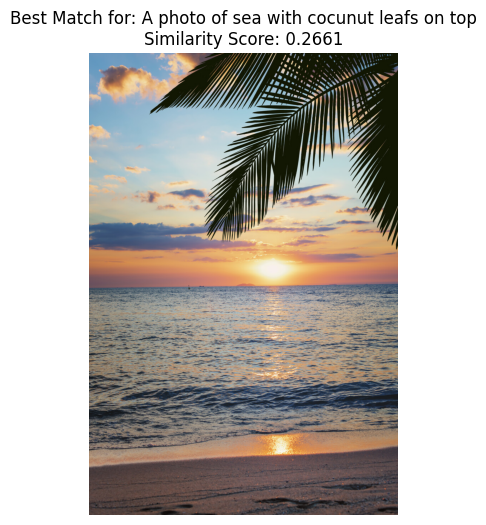

In [20]:

# ✅ Define a search query
query = "A photo of sea with cocunut leafs on top"
text_inputs = clip.tokenize([query]).to(device)

# ✅ Compute image & text features
with torch.no_grad():
    image_features = model.encode_image(image_tensors)
    text_features = model.encode_text(text_inputs)

    # Normalize features
    image_features = image_features / image_features.norm(dim=-1, keepdim=True)
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)

    # Compute similarity
    similarity = (text_features @ image_features.T).detach().cpu().numpy().flatten()

# ✅ Find the most similar image
best_match_idx = np.argmax(similarity)
best_match_image = original_images[best_match_idx]

# ✅ Display the most relevant image
plt.figure(figsize=(6, 6))
plt.imshow(best_match_image)
plt.axis("off")
plt.title(f"Best Match for: {query}\nSimilarity Score: {similarity[best_match_idx]:.4f}")
plt.show()


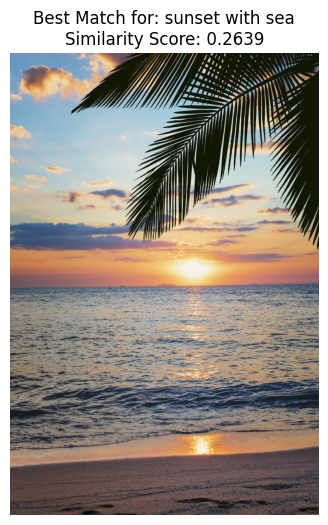

In [21]:

# ✅ Define a search query
query = "sunset with sea"
text_inputs = clip.tokenize([query]).to(device)

# ✅ Compute image & text features
with torch.no_grad():
    image_features = model.encode_image(image_tensors)
    text_features = model.encode_text(text_inputs)

    # Normalize features
    image_features = image_features / image_features.norm(dim=-1, keepdim=True)
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)

    # Compute similarity
    similarity = (text_features @ image_features.T).detach().cpu().numpy().flatten()

# ✅ Find the most similar image
best_match_idx = np.argmax(similarity)
best_match_image = original_images[best_match_idx]

# ✅ Display the most relevant image
plt.figure(figsize=(6, 6))
plt.imshow(best_match_image)
plt.axis("off")
plt.title(f"Best Match for: {query}\nSimilarity Score: {similarity[best_match_idx]:.4f}")
plt.show()


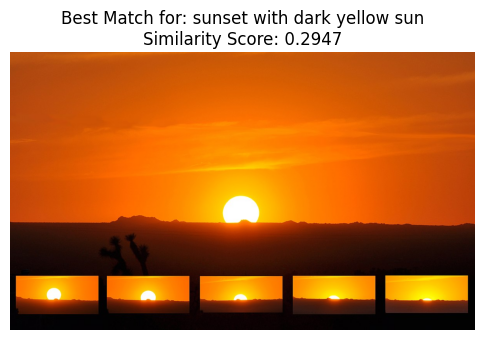

In [22]:

# ✅ Define a search query
query = "sunset with dark yellow sun"
text_inputs = clip.tokenize([query]).to(device)

# ✅ Compute image & text features
with torch.no_grad():
    image_features = model.encode_image(image_tensors)
    text_features = model.encode_text(text_inputs)

    # Normalize features
    image_features = image_features / image_features.norm(dim=-1, keepdim=True)
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)

    # Compute similarity
    similarity = (text_features @ image_features.T).detach().cpu().numpy().flatten()

# ✅ Find the most similar image
best_match_idx = np.argmax(similarity)
best_match_image = original_images[best_match_idx]

# ✅ Display the most relevant image
plt.figure(figsize=(6, 6))
plt.imshow(best_match_image)
plt.axis("off")
plt.title(f"Best Match for: {query}\nSimilarity Score: {similarity[best_match_idx]:.4f}")
plt.show()
